# Exercise 1

 Extend your LinUCB implementation to a SketchedLinUCB. Use a rank-$r$ matrix approximation (e.g. Frequent Directions) to update an approximate covariance matrix quickly. Evaluate its performance vs. full LinUCB on a context dimension $d=1024$ with 10 arms. Plot latency vs. regret as you vary the sketch rank - this illustrates the trade-off (Pareto frontier) between computational efficiency and decision quality.

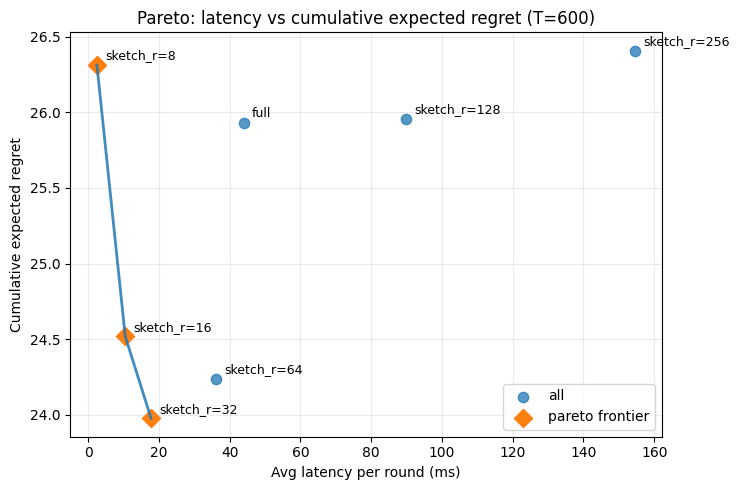

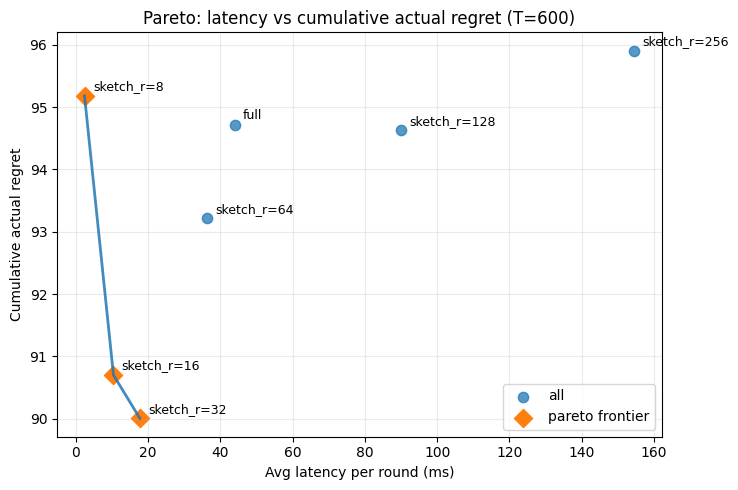

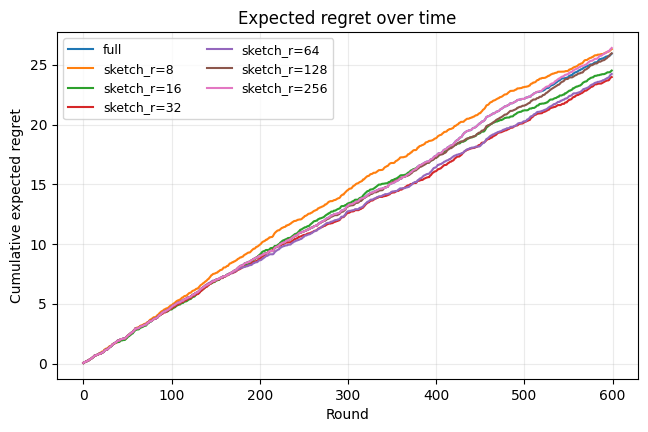

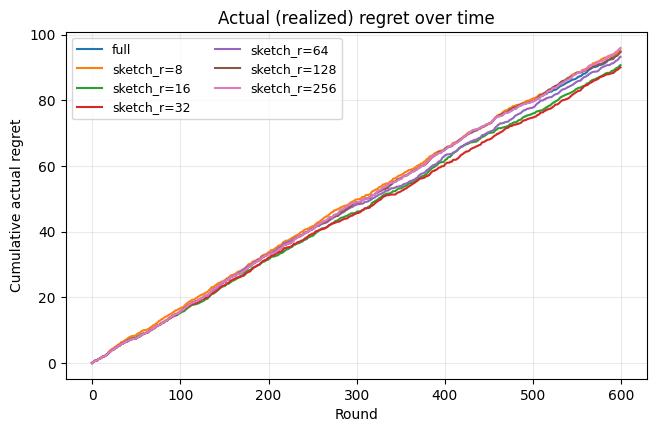

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from time import perf_counter
from typing import Dict, Iterable, Optional, Tuple

import numpy as np

# robustly impport linearucb
try:
    from Day_1.linucb import LinearUCB  
except ImportError:  
    import sys

    repo_root = Path.cwd().resolve().parent
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))

    from Day_1.linucb import LinearUCB  


class FrequentDirections:
    """Frequent Directions sketch for approximating \(\sum x x^\top\).

    - `r` is the **target rank** we keep after each compression.
    - `buffer_rows = 2*r` is the **temporary buffer capacity** before compressing.

    Implementation uses the standard "2r rows then compress" variant.
    """

    def __init__(self, d: int, r: int):
        if r <= 0:
            raise ValueError("r must be positive")
        self.d = int(d)
        self.r = int(r)

        self.buffer_rows = 2 * self.r
        self._B = np.zeros((self.buffer_rows, self.d), dtype=np.float64) # (2r, d)
        self.filled_rows = 0
        self._version = 0

    @property
    def version(self) -> int:
        return self._version 

    def add(self, x: np.ndarray) -> None:
        """Add a single vector to the sketch.

        Appends the vector to the internal buffer. When the buffer reaches
        capacity (2*r rows), it automatically triggers compression via SVD
        to maintain the sketch at rank r.

        Args:
            x: A 1-D array of length `d` to add to the sketch.

        Raises:
            ValueError: If `x` does not have length `d`.
        """
        x = np.asarray(x, dtype=np.float64).reshape(-1)
        if x.shape[0] != self.d:
            raise ValueError(f"x.shape[0]={x.shape[0]} must equal d={self.d}")

        self._B[self.filled_rows] = x
        self.filled_rows += 1

        if self.filled_rows >= self.buffer_rows:
            self._compress()

        self._version += 1

    def _compress(self) -> None:
        # SVD of (2r x d) matrix; cost ~ O(d r^2) when r << d.
        U, s, Vt = np.linalg.svd(self._B, full_matrices=False)

        # Shrink: subtract delta = s_r^2 from all singular values squared.
        delta = float(s[self.r - 1] ** 2)
        s2_shrunk = np.maximum(s**2 - delta, 0.0)
        s_shrunk = np.sqrt(s2_shrunk)

        # Keep top r components
        B_new = (s_shrunk[: self.r, None] * Vt[: self.r, :]).astype(np.float64, copy=False)

        self._B.fill(0.0)
        self._B[: self.r] = B_new
        self.filled_rows = self.r

    def compressed_B(self) -> np.ndarray:
        """Return the **latest compressed** sketch (rank ≤ r).

        After `_compress()`, the top `r` rows of `self._B` store the compressed sketch.

        If we are *between* compressions (i.e. `filled_rows > r`), then rows `r:filled_rows`
        contain newly added raw vectors that have not been folded into the sketch yet.
        This method intentionally **ignores** those pending rows and returns only the
        last compressed sketch.

        Returns:
            Array of shape `(m, d)` where `m = min(filled_rows, r)`.
        """
        m = min(self.filled_rows, self.r)
        return self._B[:m]

    def B(self) -> np.ndarray:
        """Return the current FD matrix used to approximate covariance.

        This returns all currently filled rows (up to `2*r`). That means it includes:
        - the compressed sketch rows (top `r`), and
        - any newly appended raw rows since the last compression.

        Downstream code uses `B.T @ B` as an approximation of the streamed covariance.

        Returns:
            Array view of shape `(filled_rows, d)` (so at most `(2*r, d)`).
        """
        return self._B[: self.filled_rows]


class SketchedLinUCB(LinearUCB):
    """Approximate LinUCB using a rank-r Frequent Directions covariance sketch.

    Approximates:
      V_t ≈ lam I + B^T B
    where B is the FD sketch matrix with <= r rows.

    Uses Woodbury:
      (lam I + B^T B)^{-1}
      = (1/lam)I - (1/lam^2) B^T (I + (1/lam) B B^T)^{-1} B

    Per-round costs (roughly):
      - update: FD add + occasional SVD O(d r^2)
      - scoring: O(K r d + r^3) (compute (I + BB^T/lam)^{-1} once per round)
    """

    def __init__(self, d: int, r: int, alpha: float = 1.0, lam: float = 1.0):
        super().__init__(d=d, alpha=alpha, lam=lam)

        # We do not maintain the full V_inv in this subclass.
        self._sketch = FrequentDirections(d=d, r=r) 

        self._cached_version: int = -1
        self._cached_B: Optional[np.ndarray] = None
        self._cached_G_inv: Optional[np.ndarray] = None

    def _get_B_and_Ginv(self) -> Tuple[np.ndarray, np.ndarray]:
        """Return B (m x d) and G_inv (m x m) for current sketch."""
        v = self._sketch.version
        if v == self._cached_version and self._cached_B is not None and self._cached_G_inv is not None:
            return self._cached_B, self._cached_G_inv

        B = self._sketch.B()  # (m, d)
        m = B.shape[0]

        if m == 0:
            G_inv = np.zeros((0, 0), dtype=np.float64)
        else:
            # G = I_m + (1/lam) * (B B^T)
            BBt = B @ B.T
            G = np.eye(m, dtype=np.float64) + (1.0 / self.lam) * BBt

            # Solve via Cholesky
            L = np.linalg.cholesky(G)
            # Solve G_inv = (L^T)^-1 * (L^-1) * I_m
            G_inv = np.linalg.solve(L.T, np.linalg.solve(L, np.eye(m, dtype=np.float64)))

        self._cached_version = v
        self._cached_B = B
        self._cached_G_inv = G_inv
        return B, G_inv

    def _apply_Vinv(self, v: np.ndarray) -> np.ndarray:
        """Compute approx (lam I + B^T B)^{-1} v using Woodbury."""
        v = np.asarray(v, dtype=np.float64).reshape(-1)
        if v.shape[0] != self.d:
            raise ValueError(f"v.shape[0]={v.shape[0]} must equal d={self.d}")

        B, G_inv = self._get_B_and_Ginv()
        if B.shape[0] == 0: # no data yet
            return (1.0 / self.lam) * v

        # Woodbury identity: (λI + B^T B)^{-1} v = (1/λ) v - (1/λ²) B^T G^{-1} B v
        lam_inv = 1.0 / self.lam
        t = B @ v                        # project v into sketch space: t = B v  (m,)
        corr = B.T @ (G_inv @ t)         # correction term: B^T G^{-1} t        (d,)
        return lam_inv * v - (lam_inv**2) * corr  # final Woodbury result

    def theta_hat(self) -> np.ndarray:
        return self._apply_Vinv(self.b)

    def select_arm(self, X: np.ndarray) -> int:
        X = np.asarray(X, dtype=np.float64)
        if X.ndim != 2:
            raise ValueError(f"X must be 2D, got {X.ndim}D")
        if X.shape[1] != self.d:
            raise ValueError(f"X.shape[1]={X.shape[1]} must equal d={self.d}")

        # Compute theta_hat once per round.
        th = self.theta_hat()
        B, G_inv = self._get_B_and_Ginv()

        lam_inv = 1.0 / self.lam
        scores = np.empty(X.shape[0], dtype=np.float64)

        if B.shape[0] == 0:
            # V_inv = (1/lam) I
            for i, x in enumerate(X):
                mean = float(x @ th)
                bonus = self.alpha * float(np.sqrt(lam_inv * (x @ x)))
                scores[i] = mean + bonus
            return int(np.argmax(scores))

        Bt = B.T  # precompute B^T for efficiency

        for i, x in enumerate(X):
            mean = float(x @ th)  # x^T θ_hat

            Bx = B @ x  # (B x) 
            Vinv_x = lam_inv * x - (lam_inv**2) * (Bt @ (G_inv @ Bx))  # V^{-1} x

            # max(..., 0) guards tiny negatives from floating-point error.
            bonus = self.alpha * float(np.sqrt(max(float(x @ Vinv_x), 0.0)))

            scores[i] = mean + bonus

        return int(np.argmax(scores))

    def update(self, x: np.ndarray, r: float) -> None:
        x = np.asarray(x, dtype=np.float64).reshape(-1)
        if x.shape[0] != self.d:
            raise ValueError(f"x.shape[0]={x.shape[0]} must equal d={self.d}")

        # Update sketch (approx covariance)
        self._sketch.add(x)

        # Update b exactly
        self.b += float(r) * x


@dataclass(frozen=True)
class RunResult:
    avg_ms_per_round: float

    # Expected regret uses noise-free means
    expected_cumulative_regret: float
    expected_regrets: np.ndarray

    # Actual/realized regret uses noisy realized rewards per arm
    actual_cumulative_regret: float
    actual_regrets: np.ndarray


def simulate_linear_bandit(
    agent,
    X_all: np.ndarray,
    theta_star: np.ndarray,
    noise_all: np.ndarray,
) -> RunResult:
    """Run a fixed synthetic linear contextual bandit instance.

    Shapes:
    - X_all: (T, K, d)
    - noise_all: (T, K)

    Rewards:
      r_{t,a} = x_{t,a}^T theta_star + noise_{t,a}

    Regret definitions:
    - expected regret (noise-free):  max_a x_{t,a}^T θ* - x_{t,a_t}^T θ*
    - actual regret (realized):      max_a r_{t,a} - r_{t,a_t}

    The agent is updated with the realized reward of the chosen arm.
    """

    T, K, d = X_all.shape
    theta_star = np.asarray(theta_star, dtype=np.float64).reshape(-1)
    noise_all = np.asarray(noise_all, dtype=np.float64)

    if theta_star.shape[0] != d:
        raise ValueError("theta_star dimension mismatch")
    if noise_all.shape != (T, K):
        raise ValueError(f"noise_all must have shape (T,K)={(T,K)}, got {noise_all.shape}")

    t0 = perf_counter()

    expected_regrets = np.zeros(T, dtype=np.float64)
    actual_regrets = np.zeros(T, dtype=np.float64)
    expected_cumulative = 0.0
    actual_cumulative = 0.0

    for t in range(T):
        X = X_all[t]  # (K, d)

        expected = X @ theta_star  # (K,)
        realized = expected + noise_all[t]  # (K,)

        a_star_exp = int(np.argmax(expected))
        a_star_real = int(np.argmax(realized))

        a = agent.select_arm(X)

        r = float(realized[a])
        agent.update(X[a], r)

        expected_cumulative += float(expected[a_star_exp] - expected[a])
        actual_cumulative += float(realized[a_star_real] - realized[a])

        expected_regrets[t] = expected_cumulative
        actual_regrets[t] = actual_cumulative

    elapsed = perf_counter() - t0
    return RunResult(
        avg_ms_per_round=1e3 * elapsed / T,
        expected_cumulative_regret=expected_cumulative,
        expected_regrets=expected_regrets,
        actual_cumulative_regret=actual_cumulative,
        actual_regrets=actual_regrets,
    )


def make_synthetic_instance(
    T: int,
    K: int,
    d: int,
    seed: int = 0,
    noise_std: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)

    # Keep dot-products O(1)
    X_all = (rng.normal(size=(T, K, d)).astype(np.float32)) / np.sqrt(d)

    theta_star = rng.normal(size=d).astype(np.float64)
    theta_star /= max(np.linalg.norm(theta_star), 1e-12)

    # Per-arm noise so we can define realized (actual) regret vs best realized arm.
    noise_all = rng.normal(0.0, noise_std, size=(T, K)).astype(np.float64)
    return X_all, theta_star, noise_all


# ---------------------- Benchmark: d=1024, K=10 ----------------------

def benchmark(
    T: int = 600,
    K: int = 10,
    d: int = 1024,
    ranks: Iterable[int] = (8, 16, 32, 64, 128, 256),
    alpha: float = 1.0,
    lam: float = 1.0,
    seed: int = 0,
):
    X_all, theta_star, noise_all = make_synthetic_instance(T=T, K=K, d=d, seed=seed)

    results: Dict[str, RunResult] = {}

    # Full baseline
    full = LinearUCB(d=d, alpha=alpha, lam=lam)
    results["full"] = simulate_linear_bandit(full, X_all, theta_star, noise_all)

    # Sketched variants
    for r in ranks:
        sk = SketchedLinUCB(d=d, r=int(r), alpha=alpha, lam=lam)
        results[f"sketch_r={int(r)}"] = simulate_linear_bandit(sk, X_all, theta_star, noise_all)

    return results


results = benchmark()

# ---------------------- Plot: latency vs regret (Pareto frontier) ----------------------

import matplotlib.pyplot as plt

labels = list(results.keys())
lat = np.array([results[k].avg_ms_per_round for k in labels], dtype=np.float64)

reg_exp = np.array([results[k].expected_cumulative_regret for k in labels], dtype=np.float64)
reg_act = np.array([results[k].actual_cumulative_regret for k in labels], dtype=np.float64)


def pareto_frontier_indices(latency: np.ndarray, regret: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Return indices on the Pareto frontier for minimizing (latency, regret)."""
    latency = np.asarray(latency, dtype=np.float64)
    regret = np.asarray(regret, dtype=np.float64)

    order = np.argsort(latency, kind="mergesort")

    best = np.inf
    frontier = []
    for idx in order:
        r = float(regret[idx])
        if r < best - eps:
            frontier.append(int(idx))
            best = r

    return np.array(frontier, dtype=int)


def plot_pareto(latency: np.ndarray, regret: np.ndarray, frontier_idx: np.ndarray, title: str, ylab: str):
    plt.figure(figsize=(7.5, 5.0))

    # All points
    plt.scatter(latency, regret, s=55, alpha=0.75, label="all")

    # Frontier points + connecting line (in latency order)
    f = np.array(frontier_idx, dtype=int)
    f = f[np.argsort(latency[f])]
    plt.scatter(latency[f], regret[f], s=85, marker="D", label="pareto frontier")
    plt.plot(latency[f], regret[f], linewidth=2, alpha=0.85)

    # Annotate all points for method readability
    for k, x, y in zip(labels, latency, regret):
        plt.annotate(
            k,
            (float(x), float(y)),
            textcoords="offset points",
            xytext=(6, 4),
            fontsize=9,
        )

    plt.xlabel("Avg latency per round (ms)")
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


T = len(results["full"].expected_regrets)

front_exp = pareto_frontier_indices(lat, reg_exp)
plot_pareto(
    lat,
    reg_exp,
    front_exp,
    title=f"Pareto: latency vs cumulative expected regret (T={T})",
    ylab="Cumulative expected regret",
)

front_act = pareto_frontier_indices(lat, reg_act)
plot_pareto(
    lat,
    reg_act,
    front_act,
    title=f"Pareto: latency vs cumulative actual regret (T={T})",
    ylab="Cumulative actual regret",
)

# Regret curves (expected)
plt.figure(figsize=(7.5, 4.5))
for k in labels:
    plt.plot(results[k].expected_regrets, label=k)
plt.xlabel("Round")
plt.ylabel("Cumulative expected regret")
plt.title("Expected regret over time")
plt.grid(True, alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.show()

# Regret curves (actual)
plt.figure(figsize=(7.5, 4.5))
for k in labels:
    plt.plot(results[k].actual_regrets, label=k)
plt.xlabel("Round")
plt.ylabel("Cumulative actual regret")
plt.title("Actual (realized) regret over time")
plt.grid(True, alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.show()



In [ ]:
# ---------------------- Reporting + Pareto frontiers (expected vs actual) ----------------------

import numpy as np
import matplotlib.pyplot as plt

labels = list(results.keys())
lat = np.array([results[k].avg_ms_per_round for k in labels], dtype=np.float64)
reg_exp = np.array([results[k].expected_cumulative_regret for k in labels], dtype=np.float64)
reg_act = np.array([results[k].actual_cumulative_regret for k in labels], dtype=np.float64)


def pareto_frontier_indices(latency: np.ndarray, regret: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Return indices on the Pareto frontier for minimizing (latency, regret).

    For 2D minimization, after sorting by latency ascending, a point is on the frontier
    iff it achieves a new best (strictly lower) regret so far.
    """
    latency = np.asarray(latency, dtype=np.float64)
    regret = np.asarray(regret, dtype=np.float64)

    order = np.argsort(latency, kind="mergesort")

    best = np.inf
    frontier = []
    for idx in order:
        r = float(regret[idx])
        if r < best - eps:
            frontier.append(int(idx))
            best = r

    return np.array(frontier, dtype=int)


front_exp = pareto_frontier_indices(lat, reg_exp)
front_act = pareto_frontier_indices(lat, reg_act)
front_exp_set = set(front_exp.tolist())
front_act_set = set(front_act.tolist())

# ---- Print all results (including final cumulative regret) ----
name_w = max(len(s) for s in labels)
header = (
    f"{'method':{name_w}s}  "
    f"{'lat_ms':>10s}  {'cum_reg_exp':>14s}  {'cum_reg_act':>14s}  "
    f"{'pareto_exp':>10s}  {'pareto_act':>10s}"
)
print(header)
print("-" * len(header))

for i, k in enumerate(labels):
    print(
        f"{k:{name_w}s}  "
        f"{lat[i]:10.3f}  {reg_exp[i]:14.3f}  {reg_act[i]:14.3f}  "
        f"{('yes' if i in front_exp_set else 'no'):>10s}  "
        f"{('yes' if i in front_act_set else 'no'):>10s}"
    )

print("\nPareto frontier (expected regret):")
for i in front_exp[np.argsort(lat[front_exp])]:
    print(f"- {labels[int(i)]}: latency={lat[int(i)]:.3f} ms, cum_expected_regret={reg_exp[int(i)]:.3f}")

print("\nPareto frontier (actual regret):")
for i in front_act[np.argsort(lat[front_act])]:
    print(f"- {labels[int(i)]}: latency={lat[int(i)]:.3f} ms, cum_actual_regret={reg_act[int(i)]:.3f}")


def plot_pareto(latency: np.ndarray, regret: np.ndarray, frontier_idx: np.ndarray, title: str, ylab: str):
    order = np.argsort(latency)
    plt.figure(figsize=(7.8, 5.2))

    # All points
    plt.scatter(latency, regret, s=55, alpha=0.75, label="all")

    # Frontier points + connecting line (in latency order)
    f = np.array(frontier_idx, dtype=int)
    f = f[np.argsort(latency[f])]
    plt.scatter(latency[f], regret[f], s=80, marker="D", label="pareto frontier")
    plt.plot(latency[f], regret[f], linewidth=2, alpha=0.85)

    # Annotate frontier points (cleaner than annotating everything)
    for idx in f:
        plt.annotate(
            labels[int(idx)],
            (float(latency[int(idx)]), float(regret[int(idx)])),
            textcoords="offset points",
            xytext=(6, 4),
            fontsize=9,
        )

    plt.xlabel("Avg latency per round (ms)")
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


T = len(results["full"].expected_regrets)
plot_pareto(
    lat,
    reg_exp,
    front_exp,
    title=f"Pareto: latency vs cumulative expected regret (T={T})",
    ylab="Cumulative expected regret",
)

plot_pareto(
    lat,
    reg_act,
    front_act,
    title=f"Pareto: latency vs cumulative actual regret (T={T})",
    ylab="Cumulative actual regret",
)



In [4]:
# ---------------------- Multi-seed evaluation (25 seeds): fixed alpha + regret (no plots) ----------------------

import numpy as np


def evaluate_methods_regret(
    alpha: float,
    n_seeds: int = 25,
    T: int = 600,
    K: int = 10,
    d: int = 1024,
    ranks=(8, 16, 32, 64, 128, 256),
    lam: float = 1.0,
    noise_std: float = 0.1,
    base_seed: int = 0,
):
    methods = ["full"] + [f"sketch_r={int(r)}" for r in ranks]
    exp_regs = {m: [] for m in methods}
    act_regs = {m: [] for m in methods}

    for s in range(base_seed, base_seed + n_seeds):
        X_all, theta_star, noise_all = make_synthetic_instance(
            T=T, K=K, d=d, seed=int(s), noise_std=noise_std
        )

        # Full
        agent = LinearUCB(d=d, alpha=float(alpha), lam=lam)
        rr = simulate_linear_bandit(agent, X_all, theta_star, noise_all)
        exp_regs["full"].append(float(rr.expected_cumulative_regret))
        act_regs["full"].append(float(rr.actual_cumulative_regret))

        # Sketched
        for r in ranks:
            agent = SketchedLinUCB(d=d, r=int(r), alpha=float(alpha), lam=lam)
            rr = simulate_linear_bandit(agent, X_all, theta_star, noise_all)
            key = f"sketch_r={int(r)}"
            exp_regs[key].append(float(rr.expected_cumulative_regret))
            act_regs[key].append(float(rr.actual_cumulative_regret))

    name_w = max(len(m) for m in methods)
    print(
        f"Regret averaged over {n_seeds} seeds: T={T}, K={K}, d={d}, noise_std={noise_std}, alpha={alpha}, lam={lam}"
    )
    print(
        f"{'method':{name_w}s}  {'mean_exp_reg':>14s}  {'std_exp':>10s}  {'mean_act_reg':>14s}  {'std_act':>10s}"
    )
    print("-" * (name_w + 2 + 14 + 2 + 10 + 2 + 14 + 2 + 10))

    for m in methods:
        e = np.array(exp_regs[m], dtype=np.float64)
        a = np.array(act_regs[m], dtype=np.float64)
        e_std = float(e.std(ddof=1)) if len(e) > 1 else 0.0
        a_std = float(a.std(ddof=1)) if len(a) > 1 else 0.0
        print(f"{m:{name_w}s}  {float(e.mean()):14.3f}  {e_std:10.3f}  {float(a.mean()):14.3f}  {a_std:10.3f}")


ALPHA = 0.1

evaluate_methods_regret(alpha=ALPHA, n_seeds=25)


Regret averaged over 25 seeds: T=600, K=10, d=1024, noise_std=0.1, alpha=0.1, lam=1.0
method          mean_exp_reg     std_exp    mean_act_reg     std_act
--------------------------------------------------------------------
full                  24.869       1.003          91.898       3.190
sketch_r=8            24.898       0.881          92.577       2.212
sketch_r=16           24.572       0.937          91.762       2.664
sketch_r=32           24.729       0.973          92.245       3.280
sketch_r=64           24.865       0.974          92.365       3.130
sketch_r=128          24.979       0.928          92.313       3.061
sketch_r=256          24.832       0.981          91.840       3.089


# Exercise 2

Application: Implement a simple continuous bandit using a smoothing approach. For example, optimize an LLM’s temperature setting (a continuous action in [0,1]) to maximize a reward signal (like user rating). Use a grid of possible temperatures and apply UCB with a Gaussian kernel around tried values. How does it choose diverse temperatures initially and then focus near the best one?

## Solution

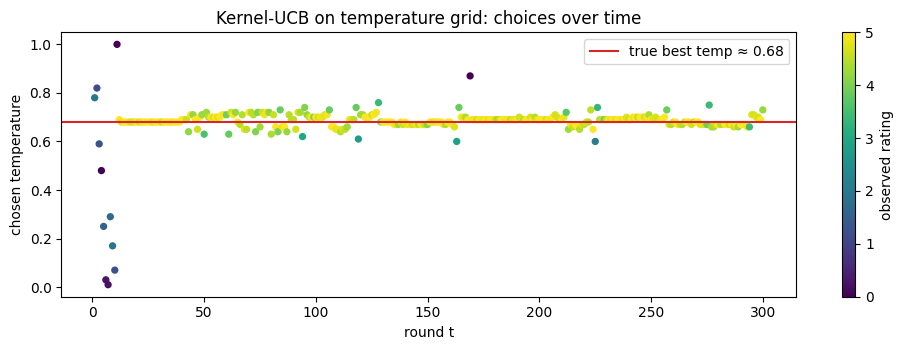

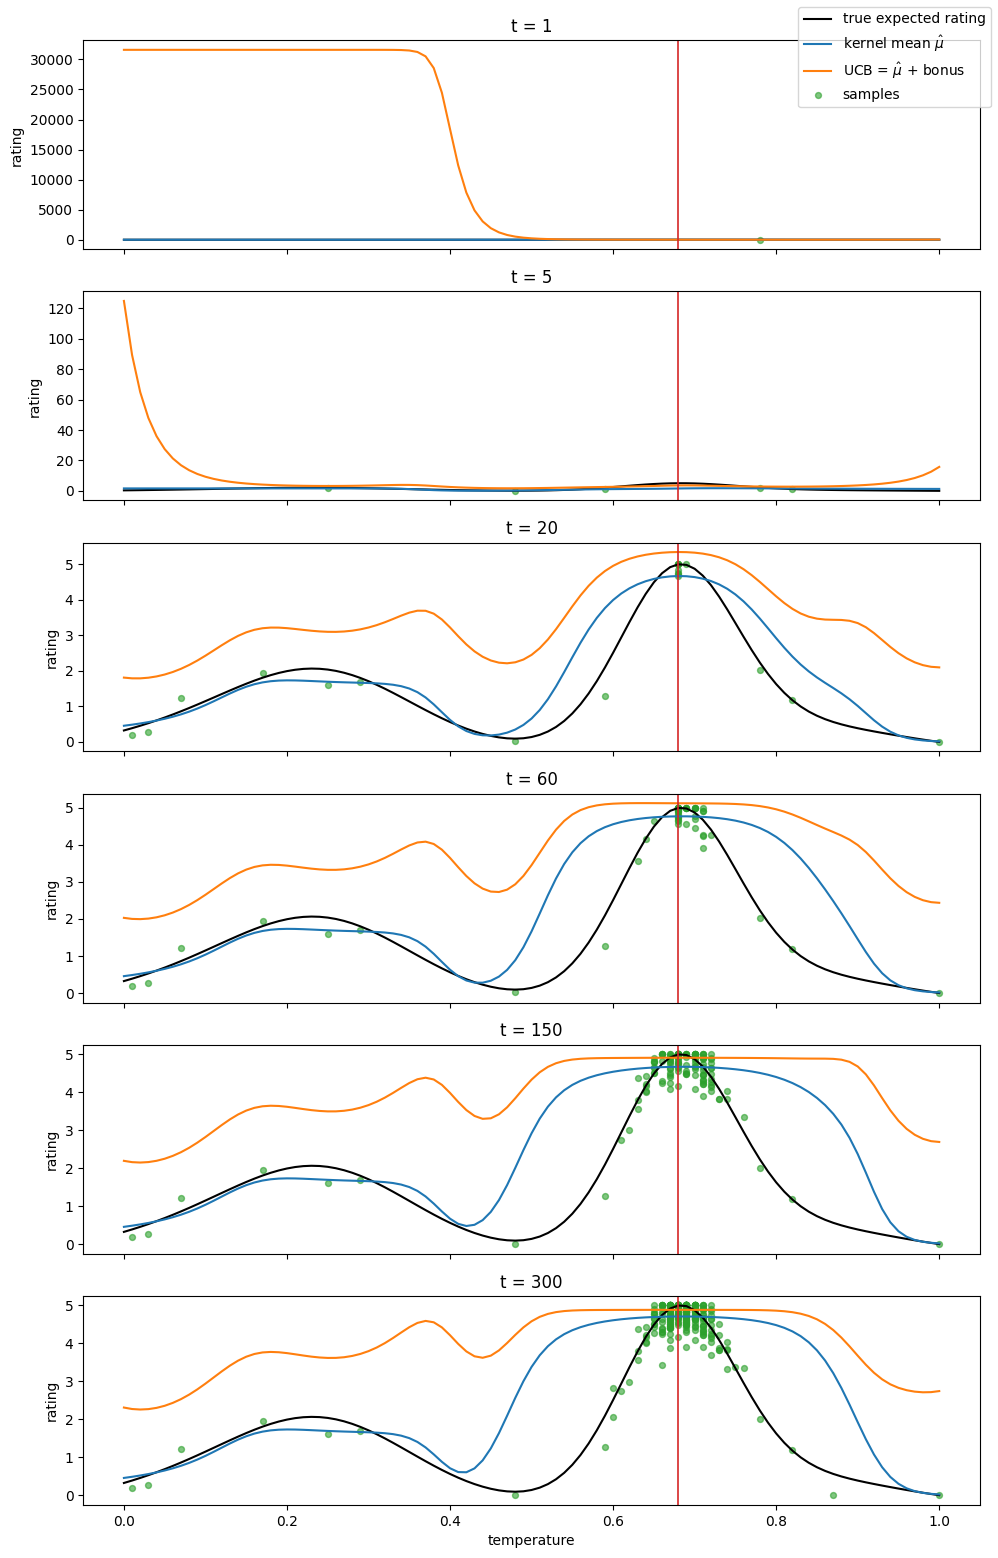

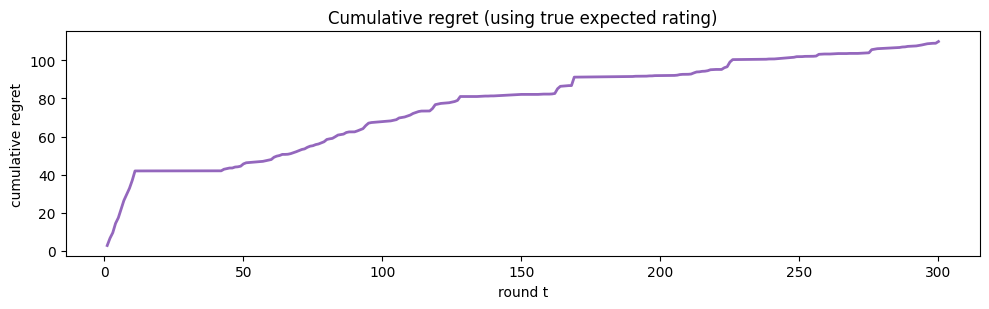

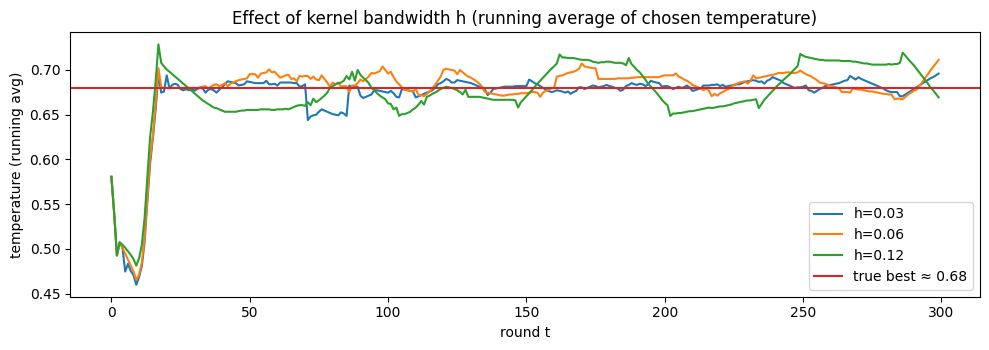

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _true_rating_raw(a: np.ndarray) -> np.ndarray:
    """
    Compute the raw (unnormalized) ground-truth rating function.

    This function simulates a complex, non-convex reward landscape for
    temperature tuning, featuring:
    - A main Gaussian peak centered at a=0.68 (optimal temperature region)
    - A secondary smaller Gaussian peak at a=0.25 (local optimum)
    - A sinusoidal wiggle component to add realistic noise/complexity

    Parameters
    ----------
    a : np.ndarray
        Temperature values in [0, 1] to evaluate.

    Returns
    -------
    np.ndarray
        Raw rating values (not yet scaled to [0, 5] range).
    """
    a = np.asarray(a, dtype=np.float64)
    peak_main = np.exp(-0.5 * ((a - 0.68) / 0.07) ** 2)
    peak_side = 0.35 * np.exp(-0.5 * ((a - 0.25) / 0.11) ** 2)
    wiggle = 0.08 * np.sin(10.0 * a)
    return peak_main + peak_side + wiggle

# Precompute normalization on a dense grid so scalar queries are correct.
_raw_grid = np.linspace(0.0, 1.0, 2001)
_raw_min = float(_true_rating_raw(_raw_grid).min())
_raw_max = float(_true_rating_raw(_raw_grid).max())

def true_rating(a: np.ndarray) -> np.ndarray:
    """Smooth ground-truth expected rating (unknown to the agent)."""
    a = np.asarray(a, dtype=np.float64)
    y = _true_rating_raw(a)
    # Normalize to [0, 1] then scale to [0, 5]
    y = (y - _raw_min) / (_raw_max - _raw_min + 1e-12)
    return 5.0 * y


def observe_reward(rng: np.random.Generator, a: float, noise_std: float = 0.35) -> float:
    r = float(true_rating(a) + rng.normal(0.0, noise_std))
    return float(np.clip(r, 0.0, 5.0))


# --- Kernel-smoothed UCB on a temperature grid ---

def kernel_ucb_scores(
    grid: np.ndarray,
    actions: np.ndarray,
    rewards: np.ndarray,
    t: int,
    h: float,
    alpha: float,
    eps: float = 1e-9,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the Upper Confidence Bound (UCB) scores for a continuous action space 
    using a Gaussian kernel smoother (Nadaraya-Watson estimator).
    # reference https://en.wikipedia.org/wiki/Kernel_regression#Nadaraya%E2%80%93Watson_kernel_regression

    For each grid point x and past samples (a_i, r_i), define Gaussian weights:

        w_i(x) = exp(-0.5 * ((x - a_i) / h)^2)

    Effective sample size near x:

        N_eff(x) = sum_i w_i(x)

    Kernel (weighted) mean reward estimate:

        mu_hat(x) = (sum_i w_i(x) * r_i) / (N_eff(x) + eps)

    UCB exploration bonus:

        bonus(x) = alpha * sqrt(log(t + 1) / (N_eff(x) + eps))

    Returned arrays (one value per grid point):

        mu_hat:  kernel mean estimate
        bonus:   exploration bonus
        score:   mu_hat + bonus (maximize this to pick the next action)

    Notes:
    - h controls how much we smooth over the grid.
    - alpha controls how strongly the algorithm explores.
    """
    grid = np.asarray(grid, dtype=np.float64)
    # Handle cold-start: no observations yet, so return uniform exploration bonus
    if actions.size == 0:
        mu_hat = np.zeros_like(grid)  
        bonus = alpha * np.sqrt(np.log(t + 1.0) / eps) * np.ones_like(grid)  =
        return mu_hat, bonus, mu_hat + bonus

    actions = np.asarray(actions, dtype=np.float64).reshape(-1)
    rewards = np.asarray(rewards, dtype=np.float64).reshape(-1)

    # Pairwise distance matrix between candidates and past actions: diff[i, j] = grid[i] - actions[j]
    # Shape: (K grid points) x (n past actions). Used to build the kernel weight matrix W.
    diff = grid[:, None] - actions[None, :]
    # Gaussian kernel weights: W[i, j] = how much action j contributes to grid point i
    W = np.exp(-0.5 * (diff / h) ** 2)

    N_eff = W.sum(axis=1)
    mu_hat = (W @ rewards) / (N_eff + eps)
    bonus = alpha * np.sqrt(np.log(t + 1.0) / (N_eff + eps))

    return mu_hat, bonus, mu_hat + bonus


# --- Run one experiment ---

rng = np.random.default_rng(0)

K = 101
T = 300
h = 0.06   
alpha = 1.2    
noise_std = 0.35

grid = np.linspace(0.0, 1.0, K)

# Pre-compute true optimum 
true_on_grid = true_rating(grid)
a_star = float(grid[int(np.argmax(true_on_grid))])
r_star = float(true_on_grid.max())

actions = np.array([], dtype=np.float64)
rewards = np.array([], dtype=np.float64)

# Force initial diversity so we can clearly see “explore first”
n_init = min(10, K)
init_idx = rng.choice(K, size=n_init, replace=False)

chosen_idx = np.empty(T, dtype=np.int64)
observed_r = np.empty(T, dtype=np.float64)
expected_r = np.empty(T, dtype=np.float64)

for t in range(1, T + 1):
    if t <= n_init: # cold start
        idx = int(init_idx[t - 1]) 
    else:
        mu_hat, bonus, score = kernel_ucb_scores(grid, actions, rewards, t=t, h=h, alpha=alpha)
        idx = int(np.argmax(score))

    a_t = float(grid[idx])  # Pick the chosen temperature value from the grid
    r_t = observe_reward(rng, a_t, noise_std=noise_std)  # Observe noisy reward for action a_t

    actions = np.append(actions, a_t)  
    rewards = np.append(rewards, r_t)  

    chosen_idx[t - 1] = idx
    observed_r[t - 1] = r_t
    expected_r[t - 1] = float(true_rating(a_t))


# --- Plots: exploration then focus ---

# 1) Chosen temperature over time
plt.figure(figsize=(10, 3.6))
plt.scatter(np.arange(1, T + 1), grid[chosen_idx], c=observed_r, s=18, cmap="viridis")
plt.axhline(a_star, color="tab:red", linewidth=1.5, label=f"true best temp ≈ {a_star:.2f}")
plt.title("Kernel-UCB on temperature grid: choices over time")
plt.xlabel("round t")
plt.ylabel("chosen temperature")
plt.colorbar(label="observed rating")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# 2) UCB curves at checkpoints
checkpoints = [1, 5, 20, 60, 150, 300]
checkpoints = [cp for cp in checkpoints if cp <= T]

fig, axes = plt.subplots(len(checkpoints), 1, figsize=(10, 2.6 * len(checkpoints)), sharex=True)
if len(checkpoints) == 1:
    axes = [axes]

for ax, cp in zip(axes, checkpoints):
    mu_hat, bonus, score = kernel_ucb_scores(
        grid,
        actions[:cp],
        rewards[:cp],
        t=cp,
        h=h,
        alpha=alpha,
    )
    ax.plot(grid, true_on_grid, color="black", linewidth=1.5, label="true expected rating")
    ax.plot(grid, mu_hat, color="tab:blue", linewidth=1.5, label="kernel mean $\\hat\\mu$")
    ax.plot(grid, score, color="tab:orange", linewidth=1.5, label="UCB = $\\hat\\mu$ + bonus")

    ax.scatter(actions[:cp], rewards[:cp], s=18, color="tab:green", alpha=0.6, label="samples")
    ax.axvline(a_star, color="tab:red", linewidth=1.2)
    ax.set_ylabel("rating")
    ax.set_title(f"t = {cp}")

axes[-1].set_xlabel("temperature")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

# 3) Regret (vs true expected best)
regret = r_star - expected_r
cum_regret = np.cumsum(regret)

plt.figure(figsize=(10, 3.2))
plt.plot(np.arange(1, T + 1), cum_regret, color="tab:purple", linewidth=2)
plt.title("Cumulative regret (using true expected rating)")
plt.xlabel("round t")
plt.ylabel("cumulative regret")
plt.tight_layout()
plt.show()


# Optional: see effect of bandwidth h

def run_bandit(h_val: float, seed: int = 0) -> np.ndarray:
    rng2 = np.random.default_rng(seed)
    actions2 = np.array([], dtype=np.float64)
    rewards2 = np.array([], dtype=np.float64)

    init_idx2 = rng2.choice(K, size=n_init, replace=False)
    chosen2 = np.empty(T, dtype=np.int64)

    for t in range(1, T + 1):
        if t <= n_init:
            idx = int(init_idx2[t - 1])
        else:
            _, _, score = kernel_ucb_scores(grid, actions2, rewards2, t=t, h=h_val, alpha=alpha)
            idx = int(np.argmax(score))

        a_t = float(grid[idx])
        r_t = observe_reward(rng2, a_t, noise_std=noise_std)

        actions2 = np.append(actions2, a_t)
        rewards2 = np.append(rewards2, r_t)
        chosen2[t - 1] = idx

    return grid[chosen2]

hs = [0.03, 0.06, 0.12]
plt.figure(figsize=(10, 3.6))
for h_val in hs:
    temps = run_bandit(h_val, seed=0)
    # show a light running average to emphasize “where it concentrates”
    window = 15
    kernel = np.ones(window) / window
    pad = window // 2
    temps_padded = np.pad(temps, (pad, pad), mode="edge")
    smoothed = np.convolve(temps_padded, kernel, mode="valid")
    plt.plot(smoothed, label=f"h={h_val}")

plt.axhline(a_star, color="tab:red", linewidth=1.5, label=f"true best ≈ {a_star:.2f}")
plt.title("Effect of kernel bandwidth h (running average of chosen temperature)")
plt.xlabel("round t")
plt.ylabel("temperature (running avg)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### Why it explores widely at first, then focuses near the best temperature

- **Smoothing (Gaussian kernel)**: when it tries a temperature $a_t$, it doesn’t only learn about $a_t$. It also updatse nearby grid points $a$ using weights

$$
 w(a,a_t) = \exp\left(-\frac{(a-a_t)^2}{2h^2}\right).
$$

So “nearby temperatures behave similarly.”

- **Early rounds = diverse exploration**:
  - The **effective sample size** at each grid point is

$$
N_{\text{eff}}(a) = \sum_{t} w(a,a_t).
$$

  - At the beginning, $N_{\text{eff}}(a)$ is small almost everywhere, so the **UCB bonus** is large:

$$
\text{bonus}(a) \propto \sqrt{\frac{\log t}{N_{\text{eff}}(a)+\varepsilon}}.
$$

  - That makes many temperatures look promising, so the algorithm tries **spread-out** values.

- **Later rounds = focus near the best**:
  - As the agent samples around a good region, $N_{\text{eff}}(a)$ becomes large there, so the bonus shrinks.
  - The kernel mean estimate $\hat\mu(a)$ becomes high near the optimum.
  - So $\hat\mu(a) + \text{bonus}(a)$ is maximized near the best temperature, and the agent **concentrates** there.

- **Bandwidth $h$** controls “how far info spreads”: small $h$ = very local learning; large $h$ = more global smoothing (faster focusing, but can oversmooth).

  - **Bias–variance tradeoff**:
    - Small $h$ **reduces bias** (far-away temperatures are not averaged together), but **increases variance** (effective sample size $N_{\text{eff}}(a)$ stays small, so estimates are noisy and bonuses stay large longer).
    - Large $h$ **reduces variance** (more smoothing ⇒ larger $N_{\text{eff}}$), but **increases bias** (regions with different true rewards can be blurred together and sharp optima can be missed).


# Exercise 3

Explain how a smoothing kernel helps a continuous bandit algorithm. In particular, describe how the kernel in CATS bridges discrete and continuous actions by generalizing the notion of “nearby” actions having similar rewards. What assumptions are needed (e.g. Lipschitz continuity), and how do they reflect in regret bounds?

## Solution


### The Role of Smoothing Kernels in Continuous Bandits 
In continuous bandit problems (action space ), standard algorithms fail because they treat infinite arms as independent. A **smoothing kernel** solves this by imposing structural correlations, allowing an agent to infer the global reward function  from limited samples. This inference relies on the reward function being "smooth," rigorously defined via Hölder continuity.


### 1. Theoretical Foundation: Generalized Smoothness

To guarantee valid learning (sub-linear regret), the reward function  must adhere to regularity conditions. The general form is **Hölder continuity**.

#### **Hölder Continuity (General Case)**

A function  is $\alpha$-Hölder continuous if, for all actions :

* **$L$:** The scaling constant (similar to a gradient bound).
* **$\alpha$:** The **Hölder exponent** (smoothness parameter). This dictates how "rough" the function is locally.
* **$0 < \alpha < 1$:** The function is extremely rough; values change abruptly over short distances.
* **$\alpha = 1$:** The function is smooth; changes are proportional to distance.

#### **Lipschitz Continuity (Special Case)**

Lipschitz continuity is simply the specific instance of Hölder continuity where the exponent is maximal ($\alpha = 1$).


* **Implication:** The function has a bounded first derivative everywhere. This is the standard assumption in many introductory bandit analyses because it represents the "nicest" possible behavior for non-differentiable functions.


### 2. How Kernels Bridge Actions (CATS)

The Continuous Arm Thompson Sampling (CATS) algorithm uses the kernel  to exploit this smoothness. The kernel acts as a proxy for the Hölder constraint.

* **Information Spreading:** When arm  is pulled yielding reward , the kernel  updates estimates for all neighboring .
* **The "Nearby" Radius:** The validity of this update depends on . The bias (error) introduced by smoothing over a bandwidth  is bounded by .
* **High $\alpha$ (Smooth/Lipschitz):** We can trust the kernel over a wider radius; "nearby" is broad.
* **Low $\alpha$ (Rough):** We can only trust the kernel over a very small radius; "nearby" is narrow.



### 3. Impact on Regret Bounds

#### **Generalized Regret Scaling**

Under $\alpha$-Hölder assumptions, the cumulative regret $R_T$ scales as:

$$
R_T = \tilde{\mathcal{O}}\left(T^{\frac{d+\alpha}{d+2\alpha}}\right)
$$

* **Role of $\alpha$:** Higher $\alpha$ (smoother functions) reduces the exponent, lowering regret.
* **Role of $d$:** Higher dimension increases the exponent (Curse of Dimensionality).

#### **Recovering the Lipschitz Bound**

Substituting the special case $\alpha = 1$ into the general formula retrieves the standard Lipschitz regret bound:

$$
R_T = \tilde{\mathcal{O}}\left(T^{\frac{d+1}{d+2}}\right)
$$


### Summary

| Feature | General Form (Hölder) | Special Case (Lipschitz) |
| --- | --- | --- |
| **Constraint** | $\lvert f(x) - f(y)\rvert \le L\,\lVert x - y\rVert^{\alpha}$ | $\lvert f(x) - f(y)\rvert \le L\,\lVert x - y\rVert$ |
| **Parameter** | $0 < \alpha \le 1$ | $\alpha = 1$ |
| **Geometry** | Allows sharp peaks/infinite slopes | Bounded slope ("Cone" constraint) |
| **Regret** | $\tilde{\mathcal{O}}\left(T^{\frac{d+\alpha}{d+2\alpha}}\right)$ | $\tilde{\mathcal{O}}\left(T^{\frac{d+1}{d+2}}\right)$ |

